# Introduction

### Problem Description

In this presentation, some toy classification problems are studied. Their common property is that raw features to be used form inefficient representations, while a bit of feature engineering can result in guaranteed perfect scores. However, for the sake of curiosity, here features are not transformed and it is measured how well Gradient Boosting can predict class labels based on initial representations.

### Software Requirements

This notebook does not use any packages beyond a list of those that are quite popular in scientific computing. Use conda or pip to install any of them.

# General Preparations

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import mpl_toolkits.mplot3d.axes3d as axes3d

# Startup settings can not suppress a warning from `xgboost` and so this is needed.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import xgboost as xgb

In [2]:
np.random.seed(361)

# Concentric Spheres

This binary classification problem is very simple. There are several concentric (probably, high-dimensional) spheres and each of them is associated with one class only. This means that radius (i.e. distance between a point and the common center of all spheres) is a "golden feature" — a classifier trained only on it can achieve superior accuracy.

Nevertheless, the question is what `xgboost` is able to achieve if it is applied in a naive straightforward fashion without radius computation.

In [3]:
def draw_from_unit_sphere(sample_size, n_dim):
    """
    Draws `sample_size` random samples
    from uniform distribution on
    `n_dim`-dimensional unit sphere.
    
    The idea is to draw samples from an
    isotropic distribution (here, normal
    distribution) and then norm them.
    
    @type sample_size: int
    @type n_dim: int
    """
    normal_sample = np.random.normal(size=(sample_size, n_dim))
    radii = np.sqrt((normal_sample ** 2).sum(axis=1))
    radii = radii.reshape((radii.shape[0], 1))
    return normal_sample / radii

Let us show that the above function works.

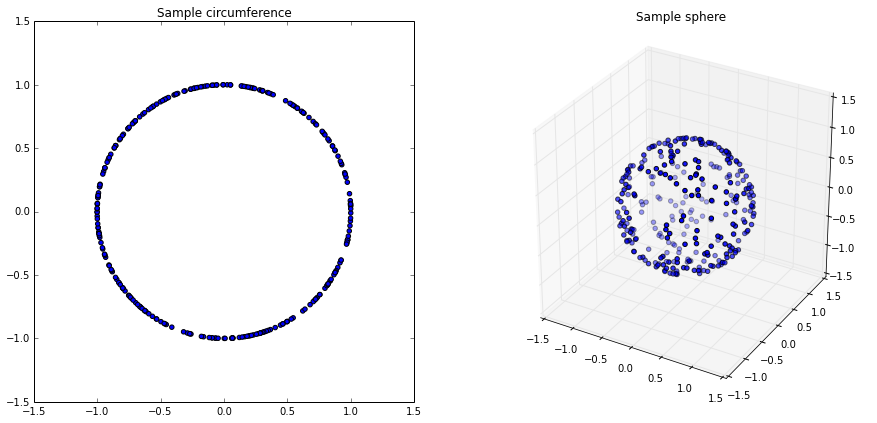

In [4]:
sample_size = 300
circumference = draw_from_unit_sphere(sample_size, 2)
three_d_sphere = draw_from_unit_sphere(sample_size, 3)

fig = plt.figure(figsize=(15, 8))

ax_one = fig.add_subplot(121)
ax_one.scatter(circumference[:, 0], circumference[:, 1])
ax_one.set_aspect('equal')
ax_one.set_title("Sample circumference")

ax_two = fig.add_subplot(122, projection='3d')
ax_two.scatter(three_d_sphere[:, 0], three_d_sphere[:, 1], three_d_sphere[:, 2])
ax_two.set_aspect('equal')
_ = ax_two.set_title("Sample sphere", y=1.075)

In [5]:
def draw_from_concentric_spheres(radii, n_dim, samples_per_sphere):
    """
    @type radii: list(float)
    @type n_dim: int
    @type samples_per_sphere: int
    """
    spheres = []
    for radius in radii:
        spheres.append(radius * draw_from_unit_sphere(samples_per_sphere, n_dim))
    spheres = np.vstack(spheres)
    return spheres

In [6]:
def synthesize_nested_spheres_dataset(radii_of_positives, radii_of_negatives,
                                      n_dim, samples_per_sphere):
    """
    Creates dataset for a binary classification
    problem, where objects are drawn from
    concentric spheres and distance from the
    origin determines the class of an object.
    
    @type radii_of_positives: list(float)
    @type radii_of_negatives: list(float)
    @type n_dim: int
    @type samples_per_sphere: int
    """
    positives = draw_from_concentric_spheres(radii_of_positives, n_dim,
                                             samples_per_sphere)
    positives = np.hstack((positives, np.ones((positives.shape[0], 1))))
    negatives = draw_from_concentric_spheres(radii_of_negatives, n_dim,
                                             samples_per_sphere)
    negatives = np.hstack((negatives, np.zeros((negatives.shape[0], 1))))
    dataset = np.vstack((positives, negatives))
    return dataset

To be continued.